In [52]:
import pandas as pd
from Historic_Crypto import HistoricalData  # Uses coinbase pro API
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Get Data

Pull from Coinbase API

In [3]:
# df = HistoricalData('ETH-BTC', 300,'2022-06-01-00-00', '2022-10-31-00-00').retrieve_data()
# df.to_csv('../../csv/ETH-BTC-300-20220601-20221031.csv')

Or read from CSV

In [4]:
df = pd.read_csv('../../csv/ETH-BTC-300-20220601-20221031.csv', index_col=0)

In [5]:
df.head()

,low,high,open,close,volume
time,,,,,
2022-06-01 00:00:00,0.06104,0.06112,0.06107,0.06111,1.173147
2022-06-01 00:05:00,0.06111,0.06112,0.06111,0.06111,0.007980
2022-06-01 00:10:00,0.06095,0.06106,0.06104,0.06106,0.771883
2022-06-01 00:15:00,0.06106,0.06109,0.06106,0.06109,1.038874
2022-06-01 00:20:00,0.06089,0.06109,0.06109,0.06089,8.765505


In [6]:
df.tail()

,low,high,open,close,volume
time,,,,,
2022-10-30 23:40:00,0.07703,0.07706,0.07705,0.07703,0.189650
2022-10-30 23:45:00,0.07708,0.07708,0.07708,0.07708,0.004659
2022-10-30 23:50:00,0.07707,0.07714,0.07707,0.07714,2.952230
2022-10-30 23:55:00,0.07711,0.07717,0.07717,0.07711,1.690949
2022-10-31 00:00:00,0.07702,0.07710,0.07709,0.07710,5.232208


# Data Sanity Checks

In [7]:
# Make time a column instead of index

df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,low,high,open,close,volume
0,2022-06-01 00:00:00,0.06104,0.06112,0.06107,0.06111,1.173147
1,2022-06-01 00:05:00,0.06111,0.06112,0.06111,0.06111,0.007980
2,2022-06-01 00:10:00,0.06095,0.06106,0.06104,0.06106,0.771883
3,2022-06-01 00:15:00,0.06106,0.06109,0.06106,0.06109,1.038874
4,2022-06-01 00:20:00,0.06089,0.06109,0.06109,0.06089,8.765505


In [8]:
# Check if there is data at every 5 min interval

lag_diff = df.time - df.time.shift(1)
print(lag_diff.min())
print(lag_diff.max())

0 days 00:05:00
0 days 00:30:00


In [9]:
# Pull cases where difference is greater than 10 mins.
# 10 mins cuz shorter TWAP on ETHUSD is 10 mins.

lag_diff[lag_diff > datetime.timedelta(minutes=10)].sort_values()

17      0 days 00:15:00
34745   0 days 00:15:00
34591   0 days 00:15:00
34583   0 days 00:15:00
34562   0 days 00:15:00
              ...      
35149   0 days 00:25:00
2296    0 days 00:25:00
880     0 days 00:25:00
34060   0 days 00:25:00
35667   0 days 00:30:00
Name: time, Length: 346, dtype: timedelta64[ns]

In [10]:
(346/df.shape[0]) * 100

# 0.85% of the data is affected

0.8562660859235796

In [11]:
# Check some problematic rows manually

df.iloc[35662:35669]

,time,low,high,open,close,volume
35662,2022-10-12 04:00:00,0.06737,0.06752,0.06737,0.06751,0.699397
35663,2022-10-12 04:05:00,0.06745,0.06751,0.06751,0.06746,0.009893
35664,2022-10-12 04:10:00,0.06749,0.06760,0.06750,0.06760,0.204218
35665,2022-10-12 04:15:00,0.06759,0.06765,0.06760,0.06759,0.398660
35666,2022-10-12 04:20:00,0.06759,0.06763,0.06759,0.06763,0.291262
35667,2022-10-12 04:50:00,0.06758,0.06761,0.06758,0.06761,0.028330
35668,2022-10-12 04:55:00,0.06760,0.06764,0.06763,0.06760,1.241839


In [12]:
# Create 2 new columns
# lag_diff_time: seconds difference between current and previous row
# lag_diff_price: percentage difference in close price between current and previous row

df['lag_diff_time'] = (df.time - df.time.shift(1)).dt.seconds
df['lag_diff_price'] = (abs(df.close - df.close.shift(1))/df.close.shift(1))*100
df.head()

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2022-06-01 00:00:00,0.06104,0.06112,0.06107,0.06111,1.173147,NaN,NaN
1,2022-06-01 00:05:00,0.06111,0.06112,0.06111,0.06111,0.007980,300.0,0.000000
2,2022-06-01 00:10:00,0.06095,0.06106,0.06104,0.06106,0.771883,300.0,0.081820
3,2022-06-01 00:15:00,0.06106,0.06109,0.06106,0.06109,1.038874,300.0,0.049132
4,2022-06-01 00:20:00,0.06089,0.06109,0.06109,0.06089,8.765505,300.0,0.327386


In [13]:
# Get max price diff % for each lag_diff_time

df_max = df[['lag_diff_time', 'lag_diff_price']]\
    .groupby('lag_diff_time').max()
df_max = df_max.sort_values(by='lag_diff_price', ascending=False).reset_index()
df_max

,lag_diff_time,lag_diff_price
0,300.0,4.483368
1,1200.0,0.672727
2,600.0,0.644038
3,900.0,0.484392
4,1500.0,0.067148
5,1800.0,0.029573


# Convert data to 10 minute TWAP

In [14]:
# Remove every alternate row to get to 10 min periodicity

twap_base = df.iloc[[i for i in range(0, len(df), 2)],]\
    .reset_index()\
    .drop('index', axis=1)
twap_base.head(10)

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price
0,2022-06-01 00:00:00,0.06104,0.06112,0.06107,0.06111,1.173147,NaN,NaN
1,2022-06-01 00:10:00,0.06095,0.06106,0.06104,0.06106,0.771883,300.0,0.081820
2,2022-06-01 00:20:00,0.06089,0.06109,0.06109,0.06089,8.765505,300.0,0.327386
3,2022-06-01 00:30:00,0.06092,0.06096,0.06094,0.06096,0.940827,300.0,0.032819
4,2022-06-01 00:40:00,0.06100,0.06103,0.06103,0.06102,0.841162,300.0,0.016391
5,2022-06-01 00:50:00,0.06104,0.06109,0.06104,0.06109,0.079717,300.0,0.114716
6,2022-06-01 01:00:00,0.06110,0.06115,0.06115,0.06110,0.004715,300.0,0.065424
7,2022-06-01 01:10:00,0.06113,0.06115,0.06115,0.06113,1.049624,300.0,0.016361
8,2022-06-01 01:20:00,0.06100,0.06110,0.06110,0.06103,5.810427,300.0,0.114566
9,2022-06-01 01:40:00,0.06098,0.06103,0.06100,0.06103,0.005326,300.0,0.049180


#### Convert to twap

In [15]:
# invert close to match uni v3
twap_base.close = 1/twap_base.close
twap_base['shift_close'] = twap_base.close.shift(1)
twap_base['twap'] = twap_base[['close', 'shift_close']].mean(axis=1)
twap_base

,time,low,high,open,close,volume,lag_diff_time,lag_diff_price,shift_close,twap
0,2022-06-01 00:00:00,0.06104,0.06112,0.06107,16.363934,1.173147,NaN,NaN,NaN,16.363934
1,2022-06-01 00:10:00,0.06095,0.06106,0.06104,16.377334,0.771883,300.0,0.081820,16.363934,16.370634
2,2022-06-01 00:20:00,0.06089,0.06109,0.06109,16.423058,8.765505,300.0,0.327386,16.377334,16.400196
3,2022-06-01 00:30:00,0.06092,0.06096,0.06094,16.404199,0.940827,300.0,0.032819,16.423058,16.413629
4,2022-06-01 00:40:00,0.06100,0.06103,0.06103,16.388069,0.841162,300.0,0.016391,16.404199,16.396134
...,...,...,...,...,...,...,...,...,...,...
20199,2022-10-30 23:00:00,0.07702,0.07715,0.07712,12.983641,0.037073,300.0,0.116716,12.975217,12.979429
20200,2022-10-30 23:15:00,0.07702,0.07705,0.07702,12.978585,0.005987,600.0,0.038951,12.983641,12.981113
20201,2022-10-30 23:30:00,0.07710,0.07718,0.07715,12.965124,0.815935,300.0,0.012963,12.978585,12.971855
20202,2022-10-30 23:45:00,0.07708,0.07708,0.07708,12.973534,0.004659,300.0,0.064910,12.965124,12.969329


# Compare against Uni V3

In [16]:
# Save data
final_df = twap_base[['time', 'twap']]
final_df.to_csv('../../csv/ETHBTC-600-20220601-20221031.csv')

In [17]:
final_df.head()

,time,twap
0,2022-06-01 00:00:00,16.363934
1,2022-06-01 00:10:00,16.370634
2,2022-06-01 00:20:00,16.400196
3,2022-06-01 00:30:00,16.413629
4,2022-06-01 00:40:00,16.396134


<AxesSubplot:>

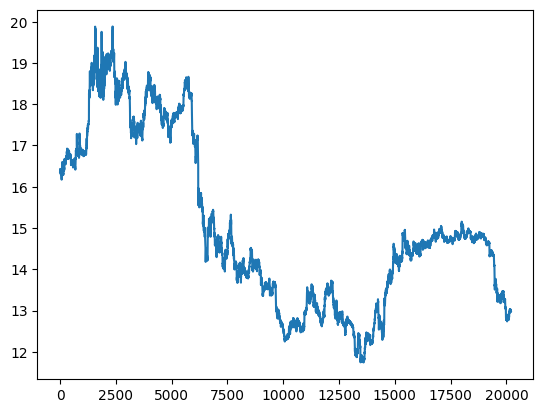

In [18]:
final_df['twap'].plot()

In [19]:
uni_df = pd.read_csv('../../csv/WBTC-WETH-10.0mTWAP-14881677-to-15864319.csv')

In [20]:
uni_df.head()

,Unnamed: 0,timestamp,twap
0,0,2022-06-01 00:01:54,16.335589
1,2,2022-06-01 00:11:54,16.345683
2,4,2022-06-01 00:21:54,16.351692
3,10,2022-06-01 00:31:54,16.361773
4,11,2022-06-01 00:41:54,16.366600


In [42]:
final_df.head()

,time,twap
0,2022-06-01 00:00:00,16.363934
1,2022-06-01 00:10:00,16.370634
2,2022-06-01 00:20:00,16.400196
3,2022-06-01 00:30:00,16.413629
4,2022-06-01 00:40:00,16.396134


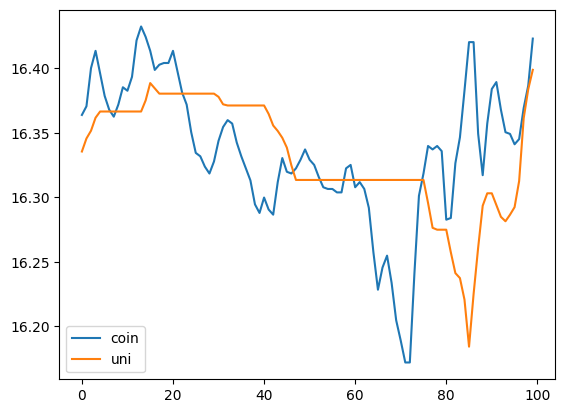

In [74]:
coin = final_df['twap']
uni = uni_df['twap']

plt.plot(coin[:100], label='coin')
plt.plot(uni[:100], label='uni')
plt.legend()
plt.show()

In [69]:
print(coin.shape, uni.shape)

(20204,) (21883,)


In [28]:
(21883 - 20204)/21883

0.07672622583740803

In [85]:
delta = pd.Timestamp(uni_df.timestamp[uni_df.shape[0]-1]) - pd.Timestamp(uni_df.timestamp[0])
print(delta.total_seconds()/600)

21882.0


In [51]:
pd.Timestamp(uni_df.timestamp.max())

Timestamp('2022-10-30 23:01:54')

In [ ]:
# THEREFORE COIN HAS MISSING DATA.
# Seems coinbase api doesn't update when price doesn't move

In [101]:
df = pd.read_csv('../../csv/ETH-BTC-300-20220601-20221031.csv', index_col=0)
df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])

In [102]:
start = datetime(2022, 6, 1, 0, 0, 0)
end = datetime(2022, 11, 1, 0, 0, 0)

timestamp_list = []
current = start
while current < end:
    timestamp_list.append(current)
    current += timedelta(minutes=5)

time_df = pd.DataFrame({'time': np.array(timestamp_list)})

In [103]:
final_df_time = time_df.merge(df, how='left', on='time')
final_df_time.close.ffill(inplace=True)

In [104]:
# Remove every alternate row to get to 10 min periodicity

final_df_time = final_df_time.iloc[[i for i in range(0, len(final_df_time), 2)],]\
    .reset_index()\
    .drop('index', axis=1)
final_df_time.head(10)

,time,low,high,open,close,volume
0,2022-06-01 00:00:00,0.06104,0.06112,0.06107,0.06111,1.173147
1,2022-06-01 00:10:00,0.06095,0.06106,0.06104,0.06106,0.771883
2,2022-06-01 00:20:00,0.06089,0.06109,0.06109,0.06089,8.765505
3,2022-06-01 00:30:00,0.06092,0.06096,0.06094,0.06096,0.940827
4,2022-06-01 00:40:00,0.06100,0.06103,0.06103,0.06102,0.841162
5,2022-06-01 00:50:00,0.06104,0.06109,0.06104,0.06109,0.079717
6,2022-06-01 01:00:00,0.06110,0.06115,0.06115,0.06110,0.004715
7,2022-06-01 01:10:00,0.06113,0.06115,0.06115,0.06113,1.049624
8,2022-06-01 01:20:00,0.06100,0.06110,0.06110,0.06103,5.810427
9,2022-06-01 01:30:00,NaN,NaN,NaN,0.06103,NaN


In [105]:
# invert close to match uni v3
final_df_time.close = 1/final_df_time.close
final_df_time['shift_close'] = final_df_time.close.shift(1)
final_df_time['twap'] = final_df_time[['close', 'shift_close']].mean(axis=1)
final_df_time = final_df_time[['time', 'twap']]

In [106]:
final_df_time

,time,twap
0,2022-06-01 00:00:00,16.363934
1,2022-06-01 00:10:00,16.370634
2,2022-06-01 00:20:00,16.400196
3,2022-06-01 00:30:00,16.413629
4,2022-06-01 00:40:00,16.396134
...,...,...
22027,2022-10-31 23:10:00,12.970169
22028,2022-10-31 23:20:00,12.970169
22029,2022-10-31 23:30:00,12.970169
22030,2022-10-31 23:40:00,12.970169


In [117]:
final_df_time.to_csv('../../csv/ETH-BTC-600-20220601-20221031-fixed.csv')

In [107]:
coin = final_df_time['twap']

In [108]:
df = pd.concat([coin,uni], axis=1)
df.columns = ['coin', 'uni']
df.head(100)

,coin,uni
0,16.363934,16.335589
1,16.370634,16.345683
2,16.400196,16.351692
3,16.413629,16.361773
4,16.396134,16.366600
...,...,...
95,16.321203,16.292466
96,16.368118,16.312704
97,16.416319,16.361390
98,16.427118,16.383901


In [136]:
fig1 = px.line(df[['coin','uni']])
fig1.show()

In [122]:
# Compare 2 hourly data

In [130]:
uni2 = pd.read_csv('../../csv/WBTC-WETH-10.0mTWAP-14881677-to-15864319_2H.csv')
coin2 = pd.read_csv('../../csv/ETH-BTC-600-20220601-20221031-fixed_2H.csv')

In [138]:
coin2s = coin2.twap
uni2s = uni2.twap
df2 = pd.concat([coin2s, uni2s], axis=1)
df2.columns = ['coin', 'uni']
fig2 = px.line(df2[['coin','uni']])
fig2.show()

In [121]:
# import pandas as pd
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# df['pct'] = (abs(df.coin - df.uni)/df.uni) * 100

# # colors = ['#636efa','#EF553B','#00cc96']

# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Line(x=df.index, y=df['coin'], showlegend=False), secondary_y=False)
# fig.add_trace(go.Line(x=df.index, y=df['uni'], showlegend=False), secondary_y=False)
# fig.add_trace(go.Bar(x=df.index, y=df['pct'], opacity=1, showlegend=False), secondary_y=True)

# # fig.update_layout(yaxis2=dict(tickvals=[0.1,0.2,0.7], tickformat='.1%', title_text='Secondary y-axis percentage'))
# # fig.update_layout(xaxis=dict(title_text='name'), yaxis=dict(title_text='values'))
# fig.show()